# Geolocating Landgriffon data - location types

## Table of Contents
- ### [Introduction](#introduction)
- ### [Python libraries](#libraries)
- ### [Import raw data](#importData)
- ### [Data exploration](#dataExploration)
    - #### [Point of production - Product unit](#PointProd)
    - #### [Processing facility](#ProcFacility)
    - #### [Origin Country](#OriCountry)
    - #### [Location Unknown](#LocUnknown)
- ### [Data geolocation](#dataGeolocation)   
- ### [Final notes](#finalNotes)


<a id='introduction'></a>
## Introduction

Example [reverse geocoding nbk](https://github.com/Vizzuality/mgis/blob/develop/data/prototype/notebooks/1.%20Test%20geocoding.ipynb) in MARS 


There are 4 different typeLocations to explore:

- Product unit: Exact location (point)
- Processing facility: Exact location (polygon)- jurisdiction
- Origin country:  (country/jurisdiction)
- Unknown: (country/jurisdiction) - weighted imports location

NOTE1: Enrich/incorporate the analysis that Ed is doing with the geocoding and inverse geocoding - https://docs.google.com/spreadsheets/d/1ymDQmzNrpLUx2SzSiy6best0Khv3xWs1wcdXvcAx4iw/edit#gid=21054469

NOTE2: We could also enrich the location data with osm data related to industrial location, orchards, silos, etc

First we check the location type field.

if the location type is 'unknown':
- We could generate a weighted layer of imports using the data from : https://resourcetrade.earth/?year=2019&importer=152&category=90&units=value&autozoom=1
- We have information of the country where the commodity is imported to but we don’t know the origin information of that commodity
- Adress field should not be empty
- lat and long should be empty
- we can add a new field for exact location. In this case, this exact location should be false.
- we can also add a new field for accuracy, being in this case accuracy low.

if the location type is 'Origin country':
- Country boundary weighted by the production of that commodity within that boundary. We can also do a more sophisticated cost transport model
- This would be the case where we know the production would be produced within the boundaries of that country. Maybe we can have tier 2 or tier 1 information.
- Adress field should not be empty
- lat and long should be empty
- we can add a new field for exact location. In this case, this exact location should be false.
- we can also add a new field for accuracy, being in this case accuracy low.

if the location type is 'Origin supplier facility (warehouse, silo, mill, etc.)':
- Admin area region weighted by the production of that commodity within the boundaries (assuming that all the commodity comes from production sites in that area. We can also do a more sophisticated cost- transport model to generate these weights.
- For the locations that we don’t know the admin area we could use a buffer instead.
- Processing facility: This would be a collection site of nearby production centers
- In this case address is always filled in and no information is provided for lat and long field. HOwever I assume that this information can be provided either by address or lat/long.
- we can add a new field for exact location. In this case, this exact location should be true.
- we can also add a new field for accuracy, being in this case accuracy medium.

if the location type is 'Point of production (farm, ranch, plantation, etc.)':
- Raster point or small raster area if we manage to get the supply shed site
- Product unit: This would be a known location for the production site (where the impact are directly taking place)
- in this case address is empty and info is provided at lat/lon level. However I would assume that this information can be provided for either field.
- we can add a new field for exact location. In this case, this exact location should be true.
- we can also add a new field for accuracy, being in this case accuracy high.

<a id='libraries'></a>
## Python libraries

In [1]:
import os

import folium
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

/Users/vizzuality/anaconda3/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.2 b55d2125) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
from processing.geolocating_data import GeolocateAddress

In [52]:
def visualise(data, z=3, loc=[0, 0], color="#f69", tooltip_property=None):
    """Maps a list of geojson features"""
    # Adapted from docs: https://geopandas.readthedocs.io/en/latest/gallery/polygon_plotting_with_folium.html

    m = folium.Map(location=loc, zoom_start=z, tiles="CartoDB positron")

    for d in data:
        geo_j = folium.GeoJson(
            data=d["geometry"],
            style_function=lambda x: {
                "fillColor": color,
                "color": color,
                "weight": 1.5,
            },
        )

        ## No popup yet
        if tooltip_property:
            prop = d["properties"].get(tooltip_property, "")
            folium.Popup(str(prop)).add_to(geo_j)

        geo_j.add_to(m)

    return m

In [3]:
point = GeolocateAddress(query="india")
point.point

Pausing 1 seconds before making HTTP GET request
Get https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&q=india with timeout=180
Geocoded "india" to (78.6677428, 22.3511148)
Params:OrderedDict([('format', 'json'), ('limit', 1), ('dedupe', 0), ('polygon_geojson', 1), ('q', 'india')])
Preparing url: https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&polygon_geojson=1&q=india


(78.6677428, 22.3511148)

In [10]:
geoms = [point.geojson]

In [40]:
visualise(geoms)

<a id='importData'></a>
## Import raw data

This data is an example of what the user could provide to the landgriffon platform.

In [23]:
input_dir = "../../data/raw/"
files = [input_dir + f for f in os.listdir(input_dir) if ".csv" in f]
files

['../../data/raw/LG fake data sheet - Raw materials.csv']

In [24]:
input_data = pd.read_csv(files[0])
input_data.head()

,Material,Material detail,Volume,Country,Address,Latitude,Longitude,Location type
0,Rubber,NaN,2400,China,NaN,NaN,NaN,Unknown
1,Rubber,NaN,1300,Malaysia,NaN,NaN,NaN,Unknown
2,Rubber,NaN,1000,United States,NaN,NaN,NaN,Unknown
3,Rubber,NaN,730,Japan,NaN,NaN,NaN,Unknown
4,Rubber,NaN,490,India,NaN,NaN,NaN,Unknown


<a id='dataExploration'></a>
## Data exploration


In [25]:
# check unique field in location type
set(input_data["Location type"])

{'Origin country',
 'Origin supplier facility (warehouse, silo, mill, etc.)',
 'Point of production (farm, ranch, plantation, etc.)',
 'Unknown'}

In [28]:
unknown_locations = input_data[input_data["Location type"] == "Unknown"]
os_facility = input_data[
    input_data["Location type"] == "Origin supplier facility (warehouse, silo, mill, etc.)"
]
oc = input_data[input_data["Location type"] == "Origin country"]
os_production = input_data[
    input_data["Location type"] == "Point of production (farm, ranch, plantation, etc.)"
]

In [31]:
print(f"The total length of the input data file is: {len(input_data)} rows/locations.\n")
print(
    f"""For those locations, there are {len(unknown_locations)}  unknown locations,
{len(os_facility)} Origin supplier facility (warehouse, silo, mill, etc locations,
{len(oc)} 'Origin country' locations and 
{len(os_production)} 'Point of production (farm, ranch, plantation, etc.)' locations
"""
)

The total length of the input data file is: 75 rows/locations.

For those locations, there are 15  unknown locations,
30 Origin supplier facility (warehouse, silo, mill, etc locations,
15 'Origin country' locations and 
15 'Point of production (farm, ranch, plantation, etc.)' locations



<a id='PointProd'></a>
### Point of production - Product unit

Raster point or small raster area if we manage to get the supply shed site. We get the point location directly from the address. 

Note: maybe we can explore the use of osm data for this type of locations depending on the raster resolution (something to explore).

In [32]:
os_production.head()

,Material,Material detail,Volume,Country,Address,Latitude,Longitude,Location type
20,Rubber,NaN,147,Indonesia,NaN,-3.10,120.24,"Point of production (farm, ranch, plantation, ..."
21,Rubber,NaN,289,Laos,NaN,20.28,100.41,"Point of production (farm, ranch, plantation, ..."
22,Rubber,NaN,362,Thailand,NaN,8.45,98.53,"Point of production (farm, ranch, plantation, ..."
23,Rubber,NaN,502,Thailand,NaN,17.01,99.75,"Point of production (farm, ranch, plantation, ..."
24,Rubber,NaN,356,Liberia,NaN,5.01,-9.04,"Point of production (farm, ranch, plantation, ..."


In [33]:
def getProductUnitLoc(gdf):
    """Adds geometry to dataframe based on lat,lon columns."""
    geoms = []
    for i in range(0, len(gdf)):
        row = gdf.iloc[i]
        rowIndex = gdf.index[i]
        lat = row["Latitude"]
        lng = row["Longitude"]
        point = (lng, lat)
        geom = Point(point)
        geoms.append(geom)
        # gdf.loc[rowIndex, 'Geometry_wkt'] = geom.to_wkt()
        gdf.loc[rowIndex, "Accuracy"] = "High"
    gdf["Geometry"] = geoms
    return gdf

In [41]:
product_unit = os_production.copy()
product_unit.head()

,Material,Material detail,Volume,Country,Address,Latitude,Longitude,Location type
20,Rubber,NaN,147,Indonesia,NaN,-3.10,120.24,"Point of production (farm, ranch, plantation, ..."
21,Rubber,NaN,289,Laos,NaN,20.28,100.41,"Point of production (farm, ranch, plantation, ..."
22,Rubber,NaN,362,Thailand,NaN,8.45,98.53,"Point of production (farm, ranch, plantation, ..."
23,Rubber,NaN,502,Thailand,NaN,17.01,99.75,"Point of production (farm, ranch, plantation, ..."
24,Rubber,NaN,356,Liberia,NaN,5.01,-9.04,"Point of production (farm, ranch, plantation, ..."


In [43]:
geolocated_gdf = getProductUnitLoc(product_unit)
geolocated_gdf.head()

,Material,Material detail,Volume,Country,Address,Latitude,Longitude,Location type,Accuracy,Geometry
20,Rubber,NaN,147,Indonesia,NaN,-3.10,120.24,"Point of production (farm, ranch, plantation, ...",High,POINT (120.24 -3.1)
21,Rubber,NaN,289,Laos,NaN,20.28,100.41,"Point of production (farm, ranch, plantation, ...",High,POINT (100.41 20.28)
22,Rubber,NaN,362,Thailand,NaN,8.45,98.53,"Point of production (farm, ranch, plantation, ...",High,POINT (98.53 8.449999999999999)
23,Rubber,NaN,502,Thailand,NaN,17.01,99.75,"Point of production (farm, ranch, plantation, ...",High,POINT (99.75 17.01)
24,Rubber,NaN,356,Liberia,NaN,5.01,-9.04,"Point of production (farm, ranch, plantation, ...",High,POINT (-9.039999999999999 5.01)


In [44]:
geolocated_gdf = geolocated_gdf.set_geometry("Geometry")

In [50]:
import json

gjson = json.loads(geolocated_gdf.to_json())
gjson

{'features': [{'geometry': {'coordinates': [120.24, -3.1], 'type': 'Point'},
   'id': '20',
   'properties': {'Accuracy': 'High',
    'Address': None,
    'Country': 'Indonesia',
    'Latitude': -3.1,
    'Location type': 'Point of production (farm, ranch, plantation, etc.)',
    'Longitude': 120.24,
    'Material': 'Rubber',
    'Material detail': None,
    'Volume': 147},
   'type': 'Feature'},
  {'geometry': {'coordinates': [100.41, 20.28], 'type': 'Point'},
   'id': '21',
   'properties': {'Accuracy': 'High',
    'Address': None,
    'Country': 'Laos',
    'Latitude': 20.28,
    'Location type': 'Point of production (farm, ranch, plantation, etc.)',
    'Longitude': 100.41,
    'Material': 'Rubber',
    'Material detail': None,
    'Volume': 289},
   'type': 'Feature'},
  {'geometry': {'coordinates': [98.53, 8.45], 'type': 'Point'},
   'id': '22',
   'properties': {'Accuracy': 'High',
    'Address': None,
    'Country': 'Thailand',
    'Latitude': 8.45,
    'Location type': 'Point 

In [53]:
visualise(gjson["features"], tooltip_property="Location type")

<a id='ProcFacility'></a>
### Processing facility

In [54]:
os_facility.head()

,Material,Material detail,Volume,Country,Address,Latitude,Longitude,Location type
10,Rubber,NaN,2300,Liberia,Margibi,NaN,NaN,"Origin supplier facility (warehouse, silo, mil..."
11,Rubber,NaN,1200,India,Kerala,NaN,NaN,"Origin supplier facility (warehouse, silo, mil..."
12,Rubber,NaN,1000,Thailand,Nakhon Si Thammarat,NaN,NaN,"Origin supplier facility (warehouse, silo, mil..."
13,Rubber,NaN,740,Thailand,Ang Thong,NaN,NaN,"Origin supplier facility (warehouse, silo, mil..."
14,Rubber,NaN,710,India,Nakhon Nayok,NaN,NaN,"Origin supplier facility (warehouse, silo, mil..."


In [56]:
processing_facility = os_facility.copy()
processing_facility.head()

,Material,Material detail,Volume,Country,Address,Latitude,Longitude,Location type
10,Rubber,NaN,2300,Liberia,Margibi,NaN,NaN,"Origin supplier facility (warehouse, silo, mil..."
11,Rubber,NaN,1200,India,Kerala,NaN,NaN,"Origin supplier facility (warehouse, silo, mil..."
12,Rubber,NaN,1000,Thailand,Nakhon Si Thammarat,NaN,NaN,"Origin supplier facility (warehouse, silo, mil..."
13,Rubber,NaN,740,Thailand,Ang Thong,NaN,NaN,"Origin supplier facility (warehouse, silo, mil..."
14,Rubber,NaN,710,India,Nakhon Nayok,NaN,NaN,"Origin supplier facility (warehouse, silo, mil..."


In [60]:
processing_facility["Full Address"] = (
    processing_facility["Address"] + ", " + processing_facility["Country"]
)
processing_facility.head()

,Material,Material detail,Volume,Country,Address,Latitude,Longitude,Location type,Full Address
10,Rubber,NaN,2300,Liberia,Margibi,NaN,NaN,"Origin supplier facility (warehouse, silo, mil...","Margibi, Liberia"
11,Rubber,NaN,1200,India,Kerala,NaN,NaN,"Origin supplier facility (warehouse, silo, mil...","Kerala, India"
12,Rubber,NaN,1000,Thailand,Nakhon Si Thammarat,NaN,NaN,"Origin supplier facility (warehouse, silo, mil...","Nakhon Si Thammarat, Thailand"
13,Rubber,NaN,740,Thailand,Ang Thong,NaN,NaN,"Origin supplier facility (warehouse, silo, mil...","Ang Thong, Thailand"
14,Rubber,NaN,710,India,Nakhon Nayok,NaN,NaN,"Origin supplier facility (warehouse, silo, mil...","Nakhon Nayok, India"


In [78]:
### Why could try and do an .apply() operation on the whole df

address = processing_facility.iloc[0]["Full Address"]
geo_loc_test = GeolocateAddress(query=address)

Pausing 1 seconds before making HTTP GET request
Get https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&q=Margibi%2C+Liberia with timeout=180
Geocoded "Margibi, Liberia" to (-10.1758429, 6.6053676)
Params:OrderedDict([('format', 'json'), ('limit', 1), ('dedupe', 0), ('polygon_geojson', 1), ('q', 'Margibi, Liberia')])
Preparing url: https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&polygon_geojson=1&q=Margibi%2C+Liberia


In [79]:
gdf = gpd.GeoDataFrame.from_features(geo_loc_test.polygon_json, crs="epsg:4326")
gdf

,geometry,place_name,bbox_north,bbox_south,bbox_east,bbox_west
0,"POLYGON ((-10.65187 6.34126, -10.64132 6.24853...","Margibi County, Liberia",6.900695,6.124568,-9.844345,-10.651866


In [83]:
m = folium.Map(location=[0, 0], tiles="cartodbpositron", zoom_start=5)
folium.GeoJson(data=gdf["geometry"]).add_to(m)
m

<a id='OriCountry'></a>
### Origin Country

In [84]:
oc.head()

,Material,Material detail,Volume,Country,Address,Latitude,Longitude,Location type
5,Rubber,NaN,3100,Thailand,NaN,NaN,NaN,Origin country
6,Rubber,NaN,2600,Indonesia,NaN,NaN,NaN,Origin country
7,Rubber,NaN,1100,Cote d'Ivoire,NaN,NaN,NaN,Origin country
8,Rubber,NaN,810,Vietnam,NaN,NaN,NaN,Origin country
9,Rubber,NaN,740,Malaysia,NaN,NaN,NaN,Origin country


In [85]:
row = processing_facility.iloc[0]
adress_country = row["Country"]
adress_country

'Liberia'

In [86]:
geo_loc_test = GeolocateAddress(query=adress_country)

Pausing 1 seconds before making HTTP GET request
Get https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&q=Liberia with timeout=180
Geocoded "Liberia" to (-9.3658524, 5.7499721)
Params:OrderedDict([('format', 'json'), ('limit', 1), ('dedupe', 0), ('polygon_geojson', 1), ('q', 'Liberia')])
Preparing url: https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&polygon_geojson=1&q=Liberia


In [87]:
gdf = gpd.GeoDataFrame.from_features(geo_loc_test.polygon_json, crs="epsg:4326")
gdf

,geometry,place_name,bbox_north,bbox_south,bbox_east,bbox_west
0,"POLYGON ((-11.60808 6.75500, -11.58668 6.73561...",Liberia,8.551925,4.155591,-7.367323,-11.608076


In [89]:
m = folium.Map(location=[0, 0], tiles="cartodbpositron", zoom_start=3)
folium.GeoJson(data=gdf["geometry"]).add_to(m)
m

<a id='LocUnknown'></a>
### Location Unknown

NOTE: For the geolocation we can do the same as the origin country location but we will compute the weighted imports raster later on the process.

<a id='dataGeolocation'></a>
## Data geolocation

In [90]:
geometry_list = []
accuracy_list = []
for i in range(0, len(input_data)):
    row = input_data.iloc[i]
    if row["Location type"] == "Unknown" or row["Location type"] == "Origin country":
        country_name = row["Country"]
        try:
            geolocation = GeolocateAddress(query=country_name)
            gdf = gpd.GeoDataFrame.from_features(geolocation.polygon_json, crs="epsg:4326")
            geom = gdf["geometry"].iloc[0]
            accuracy = "Low"
        except:
            print(f"Geolocation failed for {country_name}")
            geom = "None"
            accuracy = "None"
    if row["Location type"] == "Origin supplier facility (warehouse, silo, mill, etc.)":
        try:
            adress_count = row["Address"] + ", " + row["Country"]
            geolocation = GeolocateAddress(query=adress_count)
            gdf = gpd.GeoDataFrame.from_features(geolocation.polygon_json, crs="epsg:4326")
            geom = gdf["geometry"].iloc[0]
            accuracy = "Medium"
        except:
            print(f"Geolocation failed for row {i}")
            try:
                print("trying for country...")
                country_name = row["Country"]
                geolocation = GeolocateAddress(query=country_name)
                gdf = gpd.GeoDataFrame.from_features(geolocation.polygon_json, crs="epsg:4326")
                geom = gdf["geometry"].iloc[0]
                accuracy = "Low"
            except:
                print(f"Geolocation failed for {country_name}")
                geom = "None"
                accuracy = "None"

    if row["Location type"] == "Point of production (farm, ranch, plantation, etc.)":
        lat = row["Latitude"]
        lng = row["Longitude"]
        # point = (lat, lng)
        point = (lng, lat)
        geom = Point(point)
        accuracy = "High"

    geometry_list.append(geom)
    accuracy_list.append(accuracy)

Pausing 1 seconds before making HTTP GET request
Get https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&q=China with timeout=180
Geocoded "China" to (104.999927, 35.000074)
Params:OrderedDict([('format', 'json'), ('limit', 1), ('dedupe', 0), ('polygon_geojson', 1), ('q', 'China')])
Preparing url: https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&polygon_geojson=1&q=China
Pausing 1 seconds before making HTTP GET request
Get https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&q=Malaysia with timeout=180
Geocoded "Malaysia" to (102.2656823, 4.5693754)
Params:OrderedDict([('format', 'json'), ('limit', 1), ('dedupe', 0), ('polygon_geojson', 1), ('q', 'Malaysia')])
Preparing url: https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&polygon_geojson=1&q=Malaysia
Pausing 1 seconds before making HTTP GET request
Get https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&q=United+States with timeout

OSM returned a Point as the geometry
Pausing 1 seconds before making HTTP GET request
Get https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&q=Nagercoil%2C+Tamil+Nadu%2C+India with timeout=180
Geocoded "Nagercoil, Tamil Nadu, India" to (77.4290492, 8.1880471)
Params:OrderedDict([('format', 'json'), ('limit', 1), ('dedupe', 0), ('polygon_geojson', 1), ('q', 'Nagercoil, Tamil Nadu, India')])
Preparing url: https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&polygon_geojson=1&q=Nagercoil%2C+Tamil+Nadu%2C+India
OSM returned a Point as the geometry
Pausing 1 seconds before making HTTP GET request
Get https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&q=Phichit%2C+Phichit%2C+Thailand with timeout=180
Geocoded "Phichit, Phichit, Thailand" to (100.3430289, 16.4421088)
Params:OrderedDict([('format', 'json'), ('limit', 1), ('dedupe', 0), ('polygon_geojson', 1), ('q', 'Phichit, Phichit, Thailand')])
Preparing url: https://nominatim.ope

Pausing 1 seconds before making HTTP GET request
Get https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&q=Tianmen%2C+Hubei%2C+China with timeout=180
Geocoded "Tianmen, Hubei, China" to (113.1616191, 30.6635516)
Params:OrderedDict([('format', 'json'), ('limit', 1), ('dedupe', 0), ('polygon_geojson', 1), ('q', 'Tianmen, Hubei, China')])
Preparing url: https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&polygon_geojson=1&q=Tianmen%2C+Hubei%2C+China
Pausing 1 seconds before making HTTP GET request
Get https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&q=Casa+Grande%2C+AZ%2C+United+states with timeout=180
Geocoded "Casa Grande, AZ, United states" to (-111.7573521, 32.8795022)
Params:OrderedDict([('format', 'json'), ('limit', 1), ('dedupe', 0), ('polygon_geojson', 1), ('q', 'Casa Grande, AZ, United states')])
Preparing url: https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&polygon_geojson=1&q=Casa+Grande%2C+A

OSM returned a Point as the geometry
Pausing 1 seconds before making HTTP GET request
Get https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&q=Auckland%2C+New+Zealand with timeout=180
Geocoded "Auckland, New Zealand" to (174.7631803, -36.852095)
Params:OrderedDict([('format', 'json'), ('limit', 1), ('dedupe', 0), ('polygon_geojson', 1), ('q', 'Auckland, New Zealand')])
Preparing url: https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&polygon_geojson=1&q=Auckland%2C+New+Zealand
OSM returned a Point as the geometry
Pausing 1 seconds before making HTTP GET request
Get https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&q=Bahir+Dar%2C+Amhara%2C+Ethiopia with timeout=180
Geocoded "Bahir Dar, Amhara, Ethiopia" to (37.3879783, 11.5947981)
Params:OrderedDict([('format', 'json'), ('limit', 1), ('dedupe', 0), ('polygon_geojson', 1), ('q', 'Bahir Dar, Amhara, Ethiopia')])
Preparing url: https://nominatim.openstreetmap.org/search?format

In [91]:
print(
    f"""
lenght of geocoded locations:  {len(geometry_list)},
lenght of input data: {len(input_data)}
"""
)


lenght of geocoded locations:  75,
lenght of input data: 75



In [92]:
input_data["Geometry"] = geometry_list
input_data["Accuracy"] = accuracy_list
input_data.head()

,Material,Material detail,Volume,Country,Address,Latitude,Longitude,Location type,Geometry,Accuracy
0,Rubber,NaN,2400,China,NaN,NaN,NaN,Unknown,"(POLYGON ((73.4997347 39.3817402, 73.5000261 3...",Low
1,Rubber,NaN,1300,Malaysia,NaN,NaN,NaN,Unknown,"(POLYGON ((98.9372144 5.6838364, 98.9381013 5....",Low
2,Rubber,NaN,1000,United States,NaN,NaN,NaN,Unknown,"(POLYGON ((-180 51.7940888, -179.9926876 51.79...",Low
3,Rubber,NaN,730,Japan,NaN,NaN,NaN,Unknown,"(POLYGON ((122.7141754 24.4498321, 122.7145308...",Low
4,Rubber,NaN,490,India,NaN,NaN,NaN,Unknown,"(POLYGON ((67.9544415 23.4747156, 67.954834899...",Low


In [94]:
gdf.to_file(
    "../Processed_data/located_lg_data_polygon.shp",
    driver="ESRI Shapefile",
)

In [95]:
# check None geometries
input_data[input_data["Geometry"] == "None"]

,Material,Material detail,Volume,Country,Address,Latitude,Longitude,Location type,Geometry,Accuracy


In [96]:
gdf = gpd.GeoDataFrame(input_data, geometry="Geometry")

In [97]:
gdf_polygon = gdf[gdf["Geometry"].apply(lambda x: x.type != "Point")]
gdf_point = gdf[gdf["Geometry"].apply(lambda x: x.type == "Point")]
gdf_polygon = gdf_polygon[gdf_polygon["Geometry"].apply(lambda x: x.type != "LineString")]

In [98]:
# check the linestring data retrieved
gdf_LS = gdf[gdf["Geometry"].apply(lambda x: x.type == "LineString")]

In [99]:
gdf_LS

,Material,Material detail,Volume,Country,Address,Latitude,Longitude,Location type,Geometry,Accuracy
16,Rubber,NaN,670,Malaysia,"Keluang, Johor",NaN,NaN,"Origin supplier facility (warehouse, silo, mil...","LINESTRING (100.73784 4.83788, 100.73866 4.83752)",Medium


In [ ]:
gdf_point.to_file(
    "../Processed_data/located_lg_data_point_v2.shp",
    driver="ESRI Shapefile",
)

In [ ]:
gdf_polygon.to_file(
    "../Processed_data/located_lg_data_polygon_v2.shp",
    driver="ESRI Shapefile",
)

<AxesSubplot:>

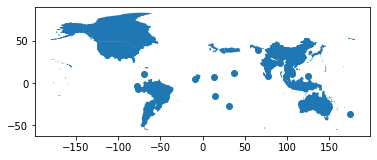

In [101]:
gdf.plot()

<a id='finalNotes'></a>
## Final notes

- We can explore later on on the process any other type of geoprocessing technology.
- Check the linestring data retrieved in the geolocate process